# DRAEM:
## A Discriminatively Trained Reconstruction Embedding for Surface Anomaly Detection
### Authors: Vitjan Zavrtanik, Matej Kristan, Danijel Skocaj

### Conference: ICCV 2021 (International Conference on Computer Vision)

### Publication Date: October 2021

### Research Paper Link: https://openaccess.thecvf.com/content/ICCV2021/papers/Zavrtanik_DRAEM_-_A_Discriminatively_Trained_Reconstruction_Embedding_for_Surface_Anomaly_ICCV_2021_paper.pdf

### GitHub Repository: https://github.com/VitjanZ/DRAEM

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install required packages
!pip install torch torchvision scikit-image scikit-learn matplotlib opencv-python kornia tqdm

# Create project directory
import os
import sys

# Set up project directory - modify this path to match your Drive structure
PROJECT_DIR = '/content/DRAEM_implementation'
!mkdir -p {PROJECT_DIR}
%cd {PROJECT_DIR}

# Create directory structure
!mkdir -p checkpoints/bottle
!mkdir -p visualizations/bottle

# Add current directory to path
sys.path.append(PROJECT_DIR)


Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 87.8 MB/s eta 0:00:00
  Attempting uninstall:

### Model Architecture

In [ ]:
%%writefile model.py
import torch
import torch.nn as nn

class DiscriminativeSubNetwork(nn.Module):
    def __init__(self, in_channels=6, out_channels=1):
        super(DiscriminativeSubNetwork, self).__init__()
        # Encoder (downsampling)
        self.conv1 = nn.Conv2d(in_channels, 64, 4, stride=2, padding=1, bias=False)  # 128x128
        self.conv2 = nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False)         # 64x64
        self.conv3 = nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=False)        # 32x32
        self.conv4 = nn.Conv2d(256, 512, 4, stride=2, padding=1, bias=False)        # 16x16

        # Decoder (upsampling)
        self.upconv1 = nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False)  # 32x32
        self.upconv2 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False)  # 64x64
        self.upconv3 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False)   # 128x128
        self.upconv4 = nn.ConvTranspose2d(64, out_channels, 4, stride=2, padding=1, bias=False)  # 256x256

        # Batch normalization
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.batchnorm3 = nn.BatchNorm2d(256)
        self.batchnorm4 = nn.BatchNorm2d(512)
        self.batchnorm5 = nn.BatchNorm2d(256)
        self.batchnorm6 = nn.BatchNorm2d(128)
        self.batchnorm7 = nn.BatchNorm2d(64)

        self.ReLU = nn.ReLU(True)

    def forward(self, x):
        # Encoder path
        x1 = self.ReLU(self.batchnorm1(self.conv1(x)))    # 128x128
        x2 = self.ReLU(self.batchnorm2(self.conv2(x1)))   # 64x64
        x3 = self.ReLU(self.batchnorm3(self.conv3(x2)))   # 32x32
        x4 = self.ReLU(self.batchnorm4(self.conv4(x3)))   # 16x16

        # Decoder path with skip connections
        x = self.ReLU(self.batchnorm5(self.upconv1(x4)))  # 32x32
        x = self.ReLU(self.batchnorm6(self.upconv2(x)))   # 64x64
        x = self.ReLU(self.batchnorm7(self.upconv3(x)))   # 128x128
        x = self.upconv4(x)                               # 256x256

        return x


class ReconstructiveSubNetwork(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, base_width=128):
        super(ReconstructiveSubNetwork, self).__init__()
        self.encoder = EncoderBlock(in_channels, base_width)
        self.decoder = DecoderBlock(base_width, out_channels)

    def forward(self, x):
        b5 = self.encoder(x)
        output = self.decoder(b5)

        return output

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(in_channels, in_channels//2, 4, stride=2, padding=1, bias=False)
        self.deconv2 = nn.ConvTranspose2d(in_channels//2, in_channels//4, 4, stride=2, padding=1, bias=False)
        self.deconv3 = nn.ConvTranspose2d(in_channels//4, in_channels//8, 4, stride=2, padding=1, bias=False)
        self.deconv4 = nn.ConvTranspose2d(in_channels//8, in_channels//16, 4, stride=2, padding=1, bias=False)
        self.deconv5 = nn.ConvTranspose2d(in_channels//16, out_channels, 4, stride=2, padding=1, bias=False)

        self.batchnorm1 = nn.BatchNorm2d(in_channels//2)
        self.batchnorm2 = nn.BatchNorm2d(in_channels//4)
        self.batchnorm3 = nn.BatchNorm2d(in_channels//8)
        self.batchnorm4 = nn.BatchNorm2d(in_channels//16)

        self.ReLU = nn.ReLU(True)
        self.Sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.ReLU(self.batchnorm1(self.deconv1(x)))
        x = self.ReLU(self.batchnorm2(self.deconv2(x)))
        x = self.ReLU(self.batchnorm3(self.deconv3(x)))
        x = self.ReLU(self.batchnorm4(self.deconv4(x)))

        x = self.Sigmoid(self.deconv5(x))

        return x

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels//16, 4, stride=2, padding=1, bias=False)
        self.conv2 = nn.Conv2d(out_channels//16, out_channels//8, 4, stride=2, padding=1, bias=False)
        self.conv3 = nn.Conv2d(out_channels//8, out_channels//4, 4, stride=2, padding=1, bias=False)
        self.conv4 = nn.Conv2d(out_channels//4, out_channels//2, 4, stride=2, padding=1, bias=False)
        self.conv5 = nn.Conv2d(out_channels//2, out_channels, 4, stride=2, padding=1, bias=False)

        self.batchnorm1 = nn.BatchNorm2d(out_channels//16)
        self.batchnorm2 = nn.BatchNorm2d(out_channels//8)
        self.batchnorm3 = nn.BatchNorm2d(out_channels//4)
        self.batchnorm4 = nn.BatchNorm2d(out_channels//2)
        self.batchnorm5 = nn.BatchNorm2d(out_channels)

        self.ReLU = nn.ReLU(True)

    def forward(self, x):
        x = self.ReLU(self.batchnorm1(self.conv1(x)))
        x = self.ReLU(self.batchnorm2(self.conv2(x)))
        x = self.ReLU(self.batchnorm3(self.conv3(x)))
        x = self.ReLU(self.batchnorm4(self.conv4(x)))
        x = self.ReLU(self.batchnorm5(self.conv5(x)))

        return x


Writing model.py


In [ ]:
%%writefile draem_model.py
import torch
import torch.nn as nn
from model import ReconstructiveSubNetwork, DiscriminativeSubNetwork

class DRAEM(nn.Module):
    def __init__(self):
        super(DRAEM, self).__init__()
        self.reconstructive_subnetwork = ReconstructiveSubNetwork()
        self.discriminative_subnetwork = DiscriminativeSubNetwork(in_channels=6)

    def forward(self, x, gt=None, mask=None, mode="train"):
        reconstructed_x = self.reconstructive_subnetwork(x)

        if mode == "train":
            output = self.discriminative_subnetwork(torch.cat((reconstructed_x, gt), dim=1))
            return reconstructed_x, output

        if mode == "test":
            output = self.discriminative_subnetwork(torch.cat((reconstructed_x, x), dim=1))
            return reconstructed_x, output

        raise ValueError(f"Invalid mode {mode}. Must be 'train' or 'test'")


Writing draem_model.py


### Dataset Modification

In [ ]:
%%writefile dataset.py
import random
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import glob
import cv2

def get_data_transforms(size, isize):
    data_transforms = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        ])
    gt_transforms = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        ])

    return data_transforms, gt_transforms

def add_gaussian_noise(image, mean=0, std=1):
    noise = torch.randn(image.size()) * std + mean
    noisy_image = image + noise
    return torch.clamp(noisy_image, 0., 1.)

class MVTecDataset(Dataset):
    def __init__(self, root, transform, gt_transform, phase, args):
        if phase=='train':
            self.img_path = os.path.join(root, args.obj_name, 'train', 'good')
        else:
            self.img_path = os.path.join(root, args.obj_name, 'test')
            self.gt_path = os.path.join(root, args.obj_name, 'ground_truth')

        self.transform = transform
        self.gt_transform = gt_transform
        self.img_paths, self.gt_paths, self.labels, self.types = self.load_dataset() # self.labels => good : 0, anomaly : 1
        self.args = args

    def load_dataset(self):
        img_tot_paths = []
        gt_tot_paths = []
        tot_labels = []
        tot_types = []

        defect_types = os.listdir(self.img_path)

        for defect_type in defect_types:
            if defect_type == 'good':
                img_paths = glob.glob(os.path.join(self.img_path, defect_type) + "/*.png")
                img_paths.extend(glob.glob(os.path.join(self.img_path, defect_type) + "/*.jpg"))
                img_tot_paths.extend(img_paths)
                gt_tot_paths.extend([0]*len(img_paths))
                tot_labels.extend([0]*len(img_paths))
                tot_types.extend(['good']*len(img_paths))
            else:
                img_paths = glob.glob(os.path.join(self.img_path, defect_type) + "/*.png")
                img_paths.extend(glob.glob(os.path.join(self.img_path, defect_type) + "/*.jpg"))
                gt_paths = []
                for img_path in img_paths:
                    gt_path = os.path.join(self.gt_path, defect_type, os.path.splitext(os.path.basename(img_path))[0] + '_mask.png')
                    gt_paths.append(gt_path)
                img_tot_paths.extend(img_paths)
                gt_tot_paths.extend(gt_paths)
                tot_labels.extend([1]*len(img_paths))
                tot_types.extend([defect_type]*len(img_paths))

        return img_tot_paths, gt_tot_paths, tot_labels, tot_types

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path, gt, label, img_type = self.img_paths[idx], self.gt_paths[idx], self.labels[idx], self.types[idx]
        img = Image.open(img_path).convert('RGB')
        img = self.transform(img)

        if gt == 0:
            gt = torch.zeros([1, img.size()[-2], img.size()[-1]])
        else:
            gt = Image.open(gt)
            gt = self.gt_transform(gt)

        return img, gt, label, os.path.basename(img_path[:-4]), img_type

class CutPasteDataset(Dataset):
    def __init__(self, root, transform, perturbed_transform, phase, args):
        self.img_path = os.path.join(root, args.obj_name, 'train', 'good')
        self.transform = transform
        self.perturbed_transform = perturbed_transform
        self.img_paths = sorted(glob.glob(self.img_path + "/*.png"))
        self.img_paths.extend(sorted(glob.glob(self.img_path + "/*.jpg")))

        # Check if anomaly source path exists and contains files
        if os.path.exists(args.anomaly_source_path):
            categories = [f for f in os.listdir(args.anomaly_source_path)
                         if os.path.isdir(os.path.join(args.anomaly_source_path, f))]
            self.anomaly_source_paths = []
            for category in categories:
                category_path = os.path.join(args.anomaly_source_path, category)
                self.anomaly_source_paths.extend(
                    [os.path.join(category_path, f) for f in os.listdir(category_path)
                     if f.endswith(('.jpg', '.png'))]
                )
        else:
            print(f"Warning: Anomaly source path {args.anomaly_source_path} not found!")
            self.anomaly_source_paths = []

        if len(self.anomaly_source_paths) == 0:
            print("No anomaly source images found! Creating synthetic textures...")
            self.create_synthetic_textures(args.anomaly_source_path)

            # Reload anomaly source paths
            categories = [f for f in os.listdir(args.anomaly_source_path)
                         if os.path.isdir(os.path.join(args.anomaly_source_path, f))]
            self.anomaly_source_paths = []
            for category in categories:
                category_path = os.path.join(args.anomaly_source_path, category)
                self.anomaly_source_paths.extend(
                    [os.path.join(category_path, f) for f in os.listdir(category_path)
                     if f.endswith(('.jpg', '.png'))]
                )

        print(f"Found {len(self.img_paths)} training images and {len(self.anomaly_source_paths)} anomaly source images")
        self.resize_transform = transforms.Resize((args.img_size, args.img_size))

    def create_synthetic_textures(self, output_path):
        """Create synthetic texture images for anomaly generation"""
        from PIL import Image
        import numpy as np

        print("Creating synthetic texture images...")
        os.makedirs(os.path.join(output_path, 'grid'), exist_ok=True)
        os.makedirs(os.path.join(output_path, 'dots'), exist_ok=True)
        os.makedirs(os.path.join(output_path, 'lines'), exist_ok=True)

        # Create 10 random textures of each type
        for i in range(10):
            # Grid texture
            grid = np.zeros((256, 256, 3), dtype=np.uint8)
            for x in range(0, 256, 16):
                for y in range(0, 256, 16):
                    grid[x:x+14, y:y+14] = np.random.randint(100, 256, size=3)
            Image.fromarray(grid).save(os.path.join(output_path, 'grid', f'{i:02d}.jpg'))

            # Dots texture
            dots = np.zeros((256, 256, 3), dtype=np.uint8)
            for _ in range(100):
                x, y = np.random.randint(0, 256, 2)
                r = np.random.randint(5, 15)
                color = np.random.randint(100, 256, size=3)
                for dx in range(-r, r+1):
                    for dy in range(-r, r+1):
                        if dx*dx + dy*dy <= r*r:
                            nx, ny = x+dx, y+dy
                            if 0 <= nx < 256 and 0 <= ny < 256:
                                dots[nx, ny] = color
            Image.fromarray(dots).save(os.path.join(output_path, 'dots', f'{i:02d}.jpg'))

            # Lines texture
            lines = np.zeros((256, 256, 3), dtype=np.uint8)
            for _ in range(20):
                x1, y1 = np.random.randint(0, 256, 2)
                x2, y2 = np.random.randint(0, 256, 2)
                thickness = np.random.randint(1, 8)
                color = np.random.randint(100, 256, size=3)

                # Draw line
                points = np.linspace(0, 1, 100)
                for t in points:
                    x = int(x1 + t * (x2 - x1))
                    y = int(y1 + t * (y2 - y1))
                    if 0 <= x < 256 and 0 <= y < 256:
                        for dx in range(-thickness//2, thickness//2+1):
                            for dy in range(-thickness//2, thickness//2+1):
                                if dx*dx + dy*dy <= thickness*thickness//4:
                                    nx, ny = x+dx, y+dy
                                    if 0 <= nx < 256 and 0 <= ny < 256:
                                        lines[nx, ny] = color

            Image.fromarray(lines).save(os.path.join(output_path, 'lines', f'{i:02d}.jpg'))

        print("Created synthetic textures successfully")

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        idx = idx % len(self.img_paths)
        img_path = self.img_paths[idx]

        img = Image.open(img_path).convert('RGB')
        img = self.transform(img)

        if len(self.anomaly_source_paths) > 0:
            anomaly_source_idx = random.randint(0, len(self.anomaly_source_paths) - 1)
            anomaly_source_path = self.anomaly_source_paths[anomaly_source_idx]

            try:
                anomaly_source_img = Image.open(anomaly_source_path).convert('RGB')
                anomaly_source_img = self.perturbed_transform(anomaly_source_img)
            except Exception as e:
                print(f"Error loading anomaly source image {anomaly_source_path}: {e}")
                # Create random noise as fallback
                anomaly_source_img = torch.rand(3, self.args.img_size, self.args.img_size)
        else:
            # No anomaly sources available - create random noise
            anomaly_source_img = torch.rand(3, self.args.img_size, self.args.img_size)

        anomaly_img = img.clone()

        beta = torch.distributions.beta.Beta(2, 2).sample((1,)).item()

        anomaly_source_img = self.resize_transform(anomaly_source_img)

        anomaly_source_img = torch.rot90(anomaly_source_img, random.randint(0,3), [1, 2])

        if random.random() > 0.5:
            anomaly_source_img = torch.flip(anomaly_source_img, dims=[random.randint(1,2)])

        anomaly_img_h, anomaly_img_w = anomaly_img.size(1), anomaly_img.size(2)
        mask_size_h = random.randint(int(anomaly_img_h * 0.05), int(anomaly_img_h * 0.2))
        mask_size_w = random.randint(int(anomaly_img_w * 0.05), int(anomaly_img_w * 0.2))

        mask_location_h = random.randint(1, anomaly_img_h - mask_size_h - 1)
        mask_location_w = random.randint(1, anomaly_img_w - mask_size_w - 1)

        anomaly_img[:, mask_location_h:mask_location_h + mask_size_h, mask_location_w:mask_location_w + mask_size_w] = anomaly_source_img[:, mask_location_h:mask_location_h + mask_size_h, mask_location_w:mask_location_w + mask_size_w]

        # for Discriminator
        mask = torch.zeros((1, anomaly_img.size(1), anomaly_img.size(2)))
        mask[:, mask_location_h:mask_location_h + mask_size_h, mask_location_w:mask_location_w + mask_size_w] = 1

        return img, anomaly_img, mask, img_path

def show_cam_on_image(img, anomaly_map):
    heatmap = cv2.applyColorMap(np.uint8(anomaly_map), cv2.COLORMAP_JET)
    cam = np.float32(heatmap) + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)


Writing dataset.py


### Train_Draem

In [ ]:
%%writefile train_DRAEM.py
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
from tqdm import tqdm
import argparse
import numpy as np
import os
import random
from dataset import CutPasteDataset, get_data_transforms
from draem_model import DRAEM
import time

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def loss_function(a, b):
    return torch.mean(torch.abs(a-b))

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def main():
    parser = argparse.ArgumentParser(description='DRAEM Implementation')
    parser.add_argument('--obj_name', default='bottle', type=str, help='Name of MVTec object to train on')
    parser.add_argument('--anomaly_source_path', default='/content/DRAEM_implementation/dtd/images', type=str, help='Directory for anomaly source images')
    parser.add_argument('--checkpoint_path', default='checkpoints', type=str, help='Directory to save models')
    parser.add_argument('--data_path', default='/content/drive/MyDrive', type=str, help='Path to parent directory containing bottle folder')
    parser.add_argument('--epochs', default=30, type=int, help='Number of training epochs')
    parser.add_argument('--lr', default=0.0001, type=float, help='Learning rate')
    parser.add_argument('--img_size', default=256, type=int, help='Image size')
    parser.add_argument('--bs', default=4, type=int, help='Batch size')
    parser.add_argument('--gpu_id', default=0, type=int, help='GPU ID')
    parser.add_argument('--seed', default=111, type=int, help='Random seed')

    args = parser.parse_args()

    # Verify dataset exists
    train_dir = os.path.join(args.data_path, args.obj_name, 'train', 'good')
    if not os.path.exists(train_dir):
        raise RuntimeError(f"Training directory not found: {train_dir}")

    train_files = [f for f in os.listdir(train_dir) if f.endswith(('.png', '.jpg'))]
    if len(train_files) == 0:
        raise RuntimeError(f"No training images found in {train_dir}")
    print(f"Found {len(train_files)} training images")

    setup_seed(args.seed)

    device = torch.device('cuda:' + str(args.gpu_id) if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    data_transform, gt_transform = get_data_transforms(args.img_size, args.img_size)

    cutpaste_transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    # Create dataset and dataloader
    train_dataset = CutPasteDataset(args.data_path, data_transform, cutpaste_transform, "train", args)

    if len(train_dataset) == 0:
        raise RuntimeError(f"Dataset loaded but contains 0 samples. Check dataset structure.")

    print(f"Dataset size: {len(train_dataset)} samples")
    train_dataloader = DataLoader(train_dataset, batch_size=args.bs, shuffle=True, num_workers=0)

    # Create model
    model = DRAEM().to(device)

    # Optimizers
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)

    # Create directory for checkpoints
    os.makedirs(args.checkpoint_path, exist_ok=True)
    os.makedirs(os.path.join(args.checkpoint_path, args.obj_name), exist_ok=True)

    # Metrics for logging
    best_loss = float('inf')

    # Training loop
    for epoch in range(args.epochs):
        model.train()
        loss_list = []

        for sample_batched in tqdm(train_dataloader):
            # Get the inputs
            original_img, perturbed_img, mask, _ = sample_batched

            original_img = original_img.to(device)
            perturbed_img = perturbed_img.to(device)
            mask = mask.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            reconstructed, output = model(perturbed_img, original_img, mask, mode="train")

            l1_loss = loss_function(reconstructed, original_img)

            segment_loss = torch.nn.functional.mse_loss(output, mask)

            loss = l1_loss + segment_loss

            loss.backward()
            optimizer.step()

            loss_list.append(loss.item())

        scheduler.step()

        # Print statistics
        epoch_loss = np.mean(loss_list)
        print(f'Epoch: {epoch + 1}/{args.epochs}, Loss: {epoch_loss:.4f}, LR: {get_lr(optimizer):.6f}')

        # Save checkpoint
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': epoch_loss,
            }, os.path.join(args.checkpoint_path, args.obj_name, f'model_best.pth'))

        # Save periodic checkpoint
        if (epoch + 1) % 10 == 0 or (epoch + 1) == args.epochs:
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': epoch_loss,
            }, os.path.join(args.checkpoint_path, args.obj_name, f'model_{epoch + 1}.pth'))

if __name__ == '__main__':
    try:
        main()
    except Exception as e:
        print(f"Error in training: {e}")
        import traceback
        traceback.print_exc()


Overwriting train_DRAEM.py


### Test_Draem

In [ ]:
%%writefile test_DRAEM.py
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import argparse
import numpy as np
import os
from dataset import MVTecDataset, get_data_transforms
from draem_model import DRAEM
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
from dataset import show_cam_on_image
import cv2
import torch.serialization

def parse_args():
    parser = argparse.ArgumentParser('DRAEM Testing')
    parser.add_argument('--gpu_id', type=int, default=0)
    parser.add_argument('--obj_name', type=str, default='bottle')
    parser.add_argument('--checkpoint_path', type=str, default='checkpoints')
    parser.add_argument('--data_path', type=str, default='/content/drive/MyDrive')
    parser.add_argument('--img_size', type=int, default=256)
    parser.add_argument('--save_path', type=str, default='visualizations')

    return parser.parse_args()

def main():
    args = parse_args()

    # Verify data exists
    test_dir = os.path.join(args.data_path, args.obj_name, 'test')
    if not os.path.exists(test_dir):
        raise RuntimeError(f"Test directory not found: {test_dir}")

    test_types = [d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))]
    if len(test_types) == 0:
        raise RuntimeError(f"No test categories found in {test_dir}")

    test_count = 0
    for d in test_types:
        test_count += len([f for f in os.listdir(os.path.join(test_dir, d)) if f.endswith(('.png', '.jpg'))])

    if test_count == 0:
        raise RuntimeError(f"No test images found in {test_dir}")

    print(f"Found {test_count} test images across {len(test_types)} categories")

    device = torch.device('cuda:' + str(args.gpu_id) if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Setup data transformations
    data_transform, gt_transform = get_data_transforms(args.img_size, args.img_size)

    # Create dataset and dataloader
    test_dataset = MVTecDataset(args.data_path, data_transform, gt_transform, "test", args)
    if len(test_dataset) == 0:
        raise RuntimeError(f"Test dataset loaded but contains 0 samples")

    print(f"Test dataset size: {len(test_dataset)} samples")
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

    # Create saving directory if it doesn't exist
    os.makedirs(os.path.join(args.save_path, args.obj_name), exist_ok=True)

   # Create model and load checkpoint
    model = DRAEM().to(device)
    checkpoint_path = os.path.join(args.checkpoint_path, args.obj_name, 'model_best.pth')

    if os.path.exists(checkpoint_path):
      try:
          # Explicitly disable weights_only for compatibility
          checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
          model.load_state_dict(checkpoint['model_state_dict'])
          print(f"Model loaded from {checkpoint_path}")
      except Exception as e:
          print(f"Error loading checkpoint: {e}")
          # Fallback to random weights
          print(f"Testing with random weights")
    else:
      print(f"No checkpoint found at {checkpoint_path}, testing with random weights")

    # Evaluation
    model.eval()

    gt_list_px = []
    pred_list_px = []
    gt_list_sp = []
    pred_list_sp = []
    img_paths = []
    img_types = []

    with torch.no_grad():
        for sample_batched in test_dataloader:
            img, gt, label, img_path, img_type = sample_batched

            img = img.to(device)
            gt = gt.to(device)

            # Forward pass
            reconstructed, output = model(img, mode="test")

            # Move results to CPU
            reconstructed = reconstructed.cpu().numpy()
            output = output.cpu().numpy()
            img = img.cpu().numpy()
            gt = gt.cpu().numpy()

            # For pixel-level detection
            for i in range(output.shape[0]):
                anomaly_map = output[i, 0]
                gt_map = gt[i, 0]

                # Ensure ground truth is binary (0 or 1)
                gt_map_binary = (gt_map > 0.5).astype(float)  # Binarize the ground truth mask

                gt_list_px.extend(gt_map_binary.ravel())
                pred_list_px.extend(anomaly_map.ravel())

                # Image-level detection
                gt_list_sp.append(label[i].item())
                pred_list_sp.append(np.max(anomaly_map))


                img_paths.append(img_path[i])
                img_types.append(img_type[i])

                # Save visualization
                if args.save_path is not None:
                    input_img = np.transpose(img[i], (1, 2, 0))
                    input_img = input_img * 255
                    input_img = input_img.astype(np.uint8)

                    # Resize anomaly map to match input image dimensions if needed
                    if anomaly_map.shape != input_img.shape[:2]:
                        anomaly_map = cv2.resize(anomaly_map,(input_img.shape[1], input_img.shape[0]),interpolation=cv2.INTER_LINEAR)

                    # Normalize anomaly map to 0-255 range
                    anomaly_map_norm = (anomaly_map - anomaly_map.min()) / (anomaly_map.max() - anomaly_map.min() + 1e-7)
                    anomaly_map_norm = anomaly_map_norm * 255
                    anomaly_map_norm = anomaly_map_norm.astype(np.uint8)

                    # Apply heatmap
                    heatmap = cv2.applyColorMap(anomaly_map_norm, cv2.COLORMAP_JET)
                    cam = np.float32(heatmap) + np.float32(input_img)
                    cam = cam / np.max(cam)
                    cam = np.uint8(255 * cam)

                    # Save original image, reconstructed image, and anomaly map
                    save_name = f"{img_path[i]}_{img_type[i]}"
                    cv2.imwrite(os.path.join(args.save_path, args.obj_name, f"{save_name}_original.png"),
                               cv2.cvtColor(input_img, cv2.COLOR_RGB2BGR))

                    recon_img = np.transpose(reconstructed[i], (1, 2, 0)) * 255
                    recon_img = recon_img.astype(np.uint8)
                    cv2.imwrite(os.path.join(args.save_path, args.obj_name, f"{save_name}_reconstructed.png"),
                               cv2.cvtColor(recon_img, cv2.COLOR_RGB2BGR))

                    cv2.imwrite(os.path.join(args.save_path, args.obj_name, f"{save_name}_anomaly_map.png"),
                               anomaly_map_norm)

                    cv2.imwrite(os.path.join(args.save_path, args.obj_name, f"{save_name}_heatmap.png"),
                               cam)

    # Calculate metrics
    pixel_auc = roc_auc_score(gt_list_px, pred_list_px)
    image_auc = roc_auc_score(gt_list_sp, pred_list_sp)

    # Calculate precision-recall AUC
    precision, recall, _ = precision_recall_curve(gt_list_px, pred_list_px)
    pixel_auprc = auc(recall, precision)

    # Print results
    print(f"Object: {args.obj_name}")
    print(f"Pixel-level AUROC: {pixel_auc:.4f}")
    print(f"Image-level AUROC: {image_auc:.4f}")
    print(f"Pixel-level AUPRC: {pixel_auprc:.4f}")

    # Save summary of results
    with open(os.path.join(args.save_path, args.obj_name, 'results.txt'), 'w') as f:
        f.write(f"Object: {args.obj_name}\n")
        f.write(f"Pixel-level AUROC: {pixel_auc:.4f}\n")
        f.write(f"Image-level AUROC: {image_auc:.4f}\n")
        f.write(f"Pixel-level AUPRC: {pixel_auprc:.4f}\n")

    # Create per-category results
    category_results = {}
    for i, img_type in enumerate(img_types):
        if img_type not in category_results:
            category_results[img_type] = {"gt": [], "pred": []}
        category_results[img_type]["gt"].append(gt_list_sp[i])
        category_results[img_type]["pred"].append(pred_list_sp[i])

    print("\nPer-category image-level AUROC:")
    for category, values in category_results.items():
        if len(set(values["gt"])) > 1:  # Need both positive and negative samples
            cat_auc = roc_auc_score(values["gt"], values["pred"])
            print(f"{category}: {cat_auc:.4f}")

    # Save ROC curve
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title(f'Pixel-level ROC Curve (AUC={pixel_auc:.4f})')
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(gt_list_px, pred_list_px)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.subplot(1, 2, 2)
    plt.title(f'Image-level ROC Curve (AUC={image_auc:.4f})')
    fpr, tpr, _ = roc_curve(gt_list_sp, pred_list_sp)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.tight_layout()
    plt.savefig(os.path.join(args.save_path, args.obj_name, 'roc_curve.png'))

    return pixel_auc, image_auc, pixel_auprc

if __name__ == '__main__':
    try:
        main()
    except Exception as e:
        print(f"Error in testing: {e}")
        import traceback
        traceback.print_exc()


Writing test_DRAEM.py


### Run_Reproduction

In [ ]:
%%writefile run_reproduction.py
import argparse
import os
import subprocess
import time

def run_command(command):
    print(f"Running: {command}")
    process = subprocess.run(command, shell=True)
    return process.returncode == 0

def main():
    parser = argparse.ArgumentParser(description='DRAEM Reproduction Pipeline')
    parser.add_argument('--mvtec_path', default='/content/drive/MyDrive',
                        help='Path to parent directory containing bottle folder')
    parser.add_argument('--dtd_path', default='/content/drive/MyDrive/dtd/images',
                        help='Path to DTD dataset on Google Drive')
    parser.add_argument('--epochs', type=int, default=30,
                        help='Number of training epochs')
    parser.add_argument('--batch_size', type=int, default=4,
                        help='Batch size for training')
    parser.add_argument('--test_only', action='store_true',
                        help='Run only testing without training')

    args = parser.parse_args()

    # Verify paths
    print("=== Verifying dataset paths ===")
    if not os.path.exists(args.mvtec_path):
        print(f"Error: MVTec path {args.mvtec_path} not found!")
        return False

    bottle_path = os.path.join(args.mvtec_path, 'bottle')
    if not os.path.exists(bottle_path):
        print(f"Error: Bottle category {bottle_path} not found!")
        return False

    # Print dataset information
    train_good = os.path.join(bottle_path, 'train', 'good')
    test_path = os.path.join(bottle_path, 'test')

    if os.path.exists(train_good):
        train_images = len([f for f in os.listdir(train_good) if f.endswith(('.png', '.jpg'))])
        print(f"Found {train_images} training images")
    else:
        print(f"Error: Training path {train_good} not found!")
        return False

    if os.path.exists(test_path):
        test_categories = [d for d in os.listdir(test_path) if os.path.isdir(os.path.join(test_path, d))]
        test_count = 0
        for cat in test_categories:
            cat_path = os.path.join(test_path, cat)
            cat_images = len([f for f in os.listdir(cat_path) if f.endswith(('.png', '.jpg'))])
            test_count += cat_images
            print(f"  - {cat}: {cat_images} images")
        print(f"Found {test_count} test images across {len(test_categories)} categories")
    else:
        print(f"Error: Test path {test_path} not found!")
        return False

    # Check DTD path
    dtd_exists = os.path.exists(args.dtd_path)
    if not dtd_exists:
        print(f"Warning: DTD path {args.dtd_path} not found. Synthetic textures will be created.")

    # Create necessary directories
    os.makedirs('checkpoints/bottle', exist_ok=True)
    os.makedirs('visualizations/bottle', exist_ok=True)

    start_time = time.time()

    # Train the model
    if not args.test_only:
        print("\n=== Training DRAEM model ===")
        if not run_command(f"python train_DRAEM.py --obj_name bottle --data_path {args.mvtec_path} --anomaly_source_path {args.dtd_path} --epochs {args.epochs} --bs {args.batch_size}"):
            print("Training failed!")
            return False

    # Test the model
    print("\n=== Testing DRAEM model ===")
    if not run_command(f"python test_DRAEM.py --obj_name bottle --data_path {args.mvtec_path}"):
        print("Testing failed!")
        return False

    total_time = time.time() - start_time
    print(f"\n=== Reproduction completed in {total_time:.2f} seconds ===")
    return True

if __name__ == "__main__":
    main()


Writing run_reproduction.py


### Evaluation on Bottle Category

In [ ]:
!wget https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz
!mkdir -p dtd
!tar -xf dtd-r1.0.1.tar.gz -C dtd
!mv dtd/dtd/* dtd/
!rm -rf dtd/dtd

--2025-03-15 12:45:49--  https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/dtd/dtd-r1.0.1.tar.gz [following]
--2025-03-15 12:45:51--  https://thor.robots.ox.ac.uk/dtd/dtd-r1.0.1.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 625239812 (596M) [application/octet-stream]
Saving to: ‘dtd-r1.0.1.tar.gz’

dtd-r1.0.1.tar.gz   100%[===================>] 596.27M  7.74MB/s    in 61s     

2025-03-15 12:46:53 (9.79 MB/s) - ‘dtd-r1.0.1.tar.gz’ saved [625239812/625239812]



In [ ]:
import os

dtd_path = "/content/DRAEM_implementation/dtd"
num_images = sum([len(files) for _, _, files in os.walk(dtd_path)])

print(f"Total images in DTD dataset: {num_images}")


Total images in DTD dataset: 5673


In [ ]:
!python run_reproduction.py --mvtec_path /content/drive/MyDrive --dtd_path /content/DRAEM_implementation/dtd/images --epochs 40 --batch_size 4


=== Verifying dataset paths ===
Found 222 training images
  - contamination: 21 images
  - broken_large: 20 images
  - broken_small: 22 images
  - good: 20 images
Found 83 test images across 4 categories

=== Training DRAEM model ===
Running: python train_DRAEM.py --obj_name bottle --data_path /content/drive/MyDrive --anomaly_source_path /content/DRAEM_implementation/dtd/images --epochs 40 --bs 4
Found 222 training images
Using device: cuda:0
Found 222 training images and 5640 anomaly source images
Dataset size: 222 samples
100% 56/56 [00:15<00:00,  3.69it/s]
Epoch: 1/40, Loss: 0.6087, LR: 0.000100
100% 56/56 [00:14<00:00,  3.91it/s]
Epoch: 2/40, Loss: 0.3385, LR: 0.000099
100% 56/56 [00:14<00:00,  3.88it/s]
Epoch: 3/40, Loss: 0.3076, LR: 0.000099
100% 56/56 [00:14<00:00,  3.88it/s]
Epoch: 4/40, Loss: 0.2691, LR: 0.000098
100% 56/56 [00:15<00:00,  3.62it/s]
Epoch: 5/40, Loss: 0.2334, LR: 0.000096
100% 56/56 [00:14<00:00,  3.96it/s]
Epoch: 6/40, Loss: 0.2022, LR: 0.000095
100% 56/56 [00

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# Path to your visualizations
viz_path = '/content/DRAEM_implementation/visualizations/bottle'

# Get all visualization files
files = os.listdir(viz_path)

# Group files by sample name
sample_groups = {}
for file in files:
    if file.endswith('.png') and not file == 'roc_curve.png':
        # Extract sample name (before the underscore and visualization type)
        parts = file.split('_')
        if len(parts) >= 3:
            sample_name = '_'.join(parts[:-1])  # Everything except the last part
            if sample_name not in sample_groups:
                sample_groups[sample_name] = []
            sample_groups[sample_name].append(file)

# Display visualizations for each sample
for sample_name, image_files in sample_groups.items():
    print(f"\n=== Visualization for {sample_name} ===")

    # Sort files to display in consistent order
    image_files.sort()

    # Create a figure with subplots
    plt.figure(figsize=(20, 5))

    for i, img_file in enumerate(image_files):
        img = cv2.imread(os.path.join(viz_path, img_file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, 4, i+1)
        plt.imshow(img)
        plt.title(img_file.split('_')[-1].replace('.png', ''))
        plt.axis('off')

    plt.tight_layout()
    plt.show()


### Evaluation on Sub-Categories of Bottle

In [ ]:
%%writefile test_DRAEM_2.py
import torch
import numpy as np
import os
import argparse
import cv2
from torch.utils.data import DataLoader
from dataset import MVTecDataset, get_data_transforms
from draem_model import DRAEM
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
from collections import defaultdict
from google.colab.patches import cv2_imshow

def parse_args():
    parser = argparse.ArgumentParser('DRAEM Testing')
    parser.add_argument('--gpu_id', type=int, default=0)
    parser.add_argument('--obj_name', type=str, default='bottle')
    parser.add_argument('--checkpoint_path', type=str, default='checkpoints')
    parser.add_argument('--data_path', type=str, default='/content/drive/MyDrive')
    parser.add_argument('--img_size', type=int, default=256)
    parser.add_argument('--save_path', type=str, default='visualizations')

    args, _ = parser.parse_known_args()  # ✅ Ignore unrecognized arguments from Jupyter
    return args

def main():
    args = parse_args()

    # Verify dataset paths
    test_dir = os.path.join(args.data_path, args.obj_name, 'test')
    if not os.path.exists(test_dir):
        raise RuntimeError(f"Test directory not found: {test_dir}")

    # Initialize metrics storage
    metrics = {
        'pixel': defaultdict(lambda: {'gt': [], 'pred': []}),
        'image': defaultdict(lambda: {'gt': [], 'pred': []})
    }

    device = torch.device(f'cuda:{args.gpu_id}' if torch.cuda.is_available() else 'cpu')

    # Load model
    model = DRAEM().to(device)
    checkpoint_path = os.path.join(args.checkpoint_path, args.obj_name, 'model_best.pth')

    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Model loaded from {checkpoint_path}")
    else:
        print(f"No checkpoint found at {checkpoint_path}")
        return

    # Data loading
    data_transform, gt_transform = get_data_transforms(args.img_size, args.img_size)
    test_dataset = MVTecDataset(args.data_path, data_transform, gt_transform, "test", args)
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    model.eval()
    with torch.no_grad():
        for sample in test_dataloader:
            img, gt, label, img_path, defect_type = sample
            img = img.to(device)
            gt = gt.to(device)

            # Get predictions
            reconstruction, prediction = model(img, mode="test")
            prediction = prediction.cpu().numpy()
            gt = gt.cpu().numpy()

            # Get texture category from defect type
            texture_category = defect_type[0] if defect_type[0] != 'good' else 'natural'

            # Store metrics
            for i in range(prediction.shape[0]):
                # Pixel-level
                gt_flat = (gt[i,0] > 0.5).astype(float).ravel()
                pred_flat = prediction[i,0].ravel()
                metrics['pixel'][texture_category]['gt'].extend(gt_flat)
                metrics['pixel'][texture_category]['pred'].extend(pred_flat)

                # Image-level
                metrics['image'][texture_category]['gt'].append(label[i].item())
                metrics['image'][texture_category]['pred'].append(prediction[i,0].max())

    # Calculate and print metrics
    print("\n=== Detailed Texture Category Metrics ===")
    for category in sorted(metrics['pixel'].keys()):
        pixel_gt = np.array(metrics['pixel'][category]['gt'])
        pixel_pred = np.array(metrics['pixel'][category]['pred'])
        image_gt = np.array(metrics['image'][category]['gt'])
        image_pred = np.array(metrics['image'][category]['pred'])

        # Pixel-level
        if len(np.unique(pixel_gt)) > 1:
            pixel_auc = roc_auc_score(pixel_gt, pixel_pred)
            precision, recall, _ = precision_recall_curve(pixel_gt, pixel_pred)
            pixel_auprc = auc(recall, precision)
        else:
            pixel_auc = pixel_auprc = np.nan

        # Image-level
        if len(np.unique(image_gt)) > 1:
            image_auc = roc_auc_score(image_gt, image_pred)
        else:
            image_auc = np.nan

        print(f"\nCategory: {category}")
        print(f"  Pixel AUROC: {pixel_auc:.4f}")
        print(f"  Pixel AUPRC: {pixel_auprc:.4f}")
        print(f"  Image AUROC: {image_auc:.4f}")

    # Calculate global metrics
    all_pixel_gt = np.concatenate([np.array(v['gt']) for v in metrics['pixel'].values()])
    all_pixel_pred = np.concatenate([np.array(v['pred']) for v in metrics['pixel'].values()])
    all_image_gt = np.concatenate([np.array(v['gt']) for v in metrics['image'].values()])
    all_image_pred = np.concatenate([np.array(v['pred']) for v in metrics['image'].values()])

    print("\n=== Global Metrics ===")
    print(f"Total Pixel AUROC: {roc_auc_score(all_pixel_gt, all_pixel_pred):.4f}")
    print(f"Total Image AUROC: {roc_auc_score(all_image_gt, all_image_pred):.4f}")

if __name__ == '__main__':
    main()


Overwriting test_DRAEM_2.py


In [ ]:
!python test_DRAEM_2.py --obj_name bottle --data_path /content/drive/MyDrive

Model loaded from checkpoints/bottle/model_best.pth

=== Detailed Texture Category Metrics ===

Category: broken_large
  Pixel AUROC: 0.8443
  Pixel AUPRC: 0.5555
  Image AUROC: nan

Category: broken_small
  Pixel AUROC: 0.9261
  Pixel AUPRC: 0.5963
  Image AUROC: nan

Category: contamination
  Pixel AUROC: 0.7572
  Pixel AUPRC: 0.4096
  Image AUROC: nan

Category: natural
  Pixel AUROC: nan
  Pixel AUPRC: nan
  Image AUROC: nan

=== Global Metrics ===
Total Pixel AUROC: 0.8365
Total Image AUROC: 0.9389


In [ ]:
%%writefile test_DRAEM.py
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import argparse
import numpy as np
import os
from dataset import MVTecDataset, get_data_transforms
from draem_model import DRAEM
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
from dataset import show_cam_on_image
import cv2
import torch.serialization

def parse_args():
    parser = argparse.ArgumentParser('DRAEM Testing')
    parser.add_argument('--gpu_id', type=int, default=0)
    parser.add_argument('--obj_name', type=str, default='bottle')
    parser.add_argument('--checkpoint_path', type=str, default='checkpoints')
    parser.add_argument('--data_path', type=str, default='/content/drive/MyDrive')
    parser.add_argument('--img_size', type=int, default=256)
    parser.add_argument('--save_path', type=str, default='visualizations')

    return parser.parse_args()

def main():
    args = parse_args()

    # Verify data exists
    test_dir = os.path.join(args.data_path, args.obj_name, 'test')
    if not os.path.exists(test_dir):
        raise RuntimeError(f"Test directory not found: {test_dir}")

    test_types = [d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))]
    if len(test_types) == 0:
        raise RuntimeError(f"No test categories found in {test_dir}")

    test_count = 0
    for d in test_types:
        test_count += len([f for f in os.listdir(os.path.join(test_dir, d)) if f.endswith(('.png', '.jpg'))])

    if test_count == 0:
        raise RuntimeError(f"No test images found in {test_dir}")

    print(f"Found {test_count} test images across {len(test_types)} categories")

    device = torch.device('cuda:' + str(args.gpu_id) if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Setup data transformations
    data_transform, gt_transform = get_data_transforms(args.img_size, args.img_size)

    # Create dataset and dataloader
    test_dataset = MVTecDataset(args.data_path, data_transform, gt_transform, "test", args)
    if len(test_dataset) == 0:
        raise RuntimeError(f"Test dataset loaded but contains 0 samples")

    print(f"Test dataset size: {len(test_dataset)} samples")
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

    # Create saving directory if it doesn't exist
    os.makedirs(os.path.join(args.save_path, args.obj_name), exist_ok=True)

   # Create model and load checkpoint
    model = DRAEM().to(device)
    checkpoint_path = os.path.join(args.checkpoint_path, args.obj_name, 'model_best.pth')

    if os.path.exists(checkpoint_path):
      try:
          # Explicitly disable weights_only for compatibility
          checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
          model.load_state_dict(checkpoint['model_state_dict'])
          print(f"Model loaded from {checkpoint_path}")
      except Exception as e:
          print(f"Error loading checkpoint: {e}")
          # Fallback to random weights
          print(f"Testing with random weights")
    else:
      print(f"No checkpoint found at {checkpoint_path}, testing with random weights")

    # Evaluation
    model.eval()

    gt_list_px = []
    pred_list_px = []
    gt_list_sp = []
    pred_list_sp = []
    img_paths = []
    img_types = []

    with torch.no_grad():
        for sample_batched in test_dataloader:
            img, gt, label, img_path, img_type = sample_batched

            img = img.to(device)
            gt = gt.to(device)

            # Forward pass
            reconstructed, output = model(img, mode="test")

            # Move results to CPU
            reconstructed = reconstructed.cpu().numpy()
            output = output.cpu().numpy()
            img = img.cpu().numpy()
            gt = gt.cpu().numpy()

            # For pixel-level detection
            for i in range(output.shape[0]):
                anomaly_map = output[i, 0]
                gt_map = gt[i, 0]

                # Ensure ground truth is binary (0 or 1)
                gt_map_binary = (gt_map > 0.5).astype(float)  # Binarize the ground truth mask

                gt_list_px.extend(gt_map_binary.ravel())
                pred_list_px.extend(anomaly_map.ravel())

                # Image-level detection
                gt_list_sp.append(label[i].item())
                pred_list_sp.append(np.max(anomaly_map))


                img_paths.append(img_path[i])
                img_types.append(img_type[i])

                # Save visualization
                if args.save_path is not None:
                    input_img = np.transpose(img[i], (1, 2, 0))
                    input_img = input_img * 255
                    input_img = input_img.astype(np.uint8)

                    # Resize anomaly map to match input image dimensions if needed
                    if anomaly_map.shape != input_img.shape[:2]:
                        anomaly_map = cv2.resize(anomaly_map,(input_img.shape[1], input_img.shape[0]),interpolation=cv2.INTER_LINEAR)

                    # Normalize anomaly map to 0-255 range
                    anomaly_map_norm = (anomaly_map - anomaly_map.min()) / (anomaly_map.max() - anomaly_map.min() + 1e-7)
                    anomaly_map_norm = anomaly_map_norm * 255
                    anomaly_map_norm = anomaly_map_norm.astype(np.uint8)

                    # Apply heatmap
                    heatmap = cv2.applyColorMap(anomaly_map_norm, cv2.COLORMAP_JET)
                    cam = np.float32(heatmap) + np.float32(input_img)
                    cam = cam / np.max(cam)
                    cam = np.uint8(255 * cam)

                    # Save original image, reconstructed image, and anomaly map
                    save_name = f"{img_path[i]}_{img_type[i]}"
                    cv2.imwrite(os.path.join(args.save_path, args.obj_name, f"{save_name}_original.png"),
                               cv2.cvtColor(input_img, cv2.COLOR_RGB2BGR))

                    recon_img = np.transpose(reconstructed[i], (1, 2, 0)) * 255
                    recon_img = recon_img.astype(np.uint8)
                    cv2.imwrite(os.path.join(args.save_path, args.obj_name, f"{save_name}_reconstructed.png"),
                               cv2.cvtColor(recon_img, cv2.COLOR_RGB2BGR))

                    cv2.imwrite(os.path.join(args.save_path, args.obj_name, f"{save_name}_anomaly_map.png"),
                               anomaly_map_norm)

                    cv2.imwrite(os.path.join(args.save_path, args.obj_name, f"{save_name}_heatmap.png"),
                               cam)

    # Calculate metrics
    pixel_auc = roc_auc_score(gt_list_px, pred_list_px)
    image_auc = roc_auc_score(gt_list_sp, pred_list_sp)

    # Calculate precision-recall AUC
    precision, recall, _ = precision_recall_curve(gt_list_px, pred_list_px)
    pixel_auprc = auc(recall, precision)

    # Print results
    print(f"Object: {args.obj_name}")
    print(f"Pixel-level AUROC: {pixel_auc:.4f}")
    print(f"Image-level AUROC: {image_auc:.4f}")
    print(f"Pixel-level AUPRC: {pixel_auprc:.4f}")

    # Save summary of results
    with open(os.path.join(args.save_path, args.obj_name, 'results.txt'), 'w') as f:
        f.write(f"Object: {args.obj_name}\n")
        f.write(f"Pixel-level AUROC: {pixel_auc:.4f}\n")
        f.write(f"Image-level AUROC: {image_auc:.4f}\n")
        f.write(f"Pixel-level AUPRC: {pixel_auprc:.4f}\n")

    # Create per-category results
    category_results = {}
    for i, img_type in enumerate(img_types):
        if img_type not in category_results:
            category_results[img_type] = {"gt": [], "pred": []}
        category_results[img_type]["gt"].append(gt_list_sp[i])
        category_results[img_type]["pred"].append(pred_list_sp[i])

    print("\nPer-category image-level AUROC:")
    for category, values in category_results.items():
        if len(set(values["gt"])) > 1:  # Need both positive and negative samples
            cat_auc = roc_auc_score(values["gt"], values["pred"])
            print(f"{category}: {cat_auc:.4f}")

    # Save ROC curve
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title(f'Pixel-level ROC Curve (AUC={pixel_auc:.4f})')
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(gt_list_px, pred_list_px)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.subplot(1, 2, 2)
    plt.title(f'Image-level ROC Curve (AUC={image_auc:.4f})')
    fpr, tpr, _ = roc_curve(gt_list_sp, pred_list_sp)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.tight_layout()
    plt.savefig(os.path.join(args.save_path, args.obj_name, 'roc_curve.png'))

    # Save evaluation data for visualization
    np.savez('results.npz',
            gt_list_px=gt_list_px,
            pred_list_px=pred_list_px,
            gt_list_sp=gt_list_sp,
            pred_list_sp=pred_list_sp)

    print("Results saved to results.npz")

    return pixel_auc, image_auc, pixel_auprc

if __name__ == '__main__':
    try:
        main()
    except Exception as e:
        print(f"Error in testing: {e}")
        import traceback
        traceback.print_exc()


Overwriting test_DRAEM.py


In [ ]:
!python test_DRAEM.py --obj_name bottle --data_path /content/drive/MyDrive

Found 83 test images across 4 categories
Using device: cuda:0
Test dataset size: 83 samples
Model loaded from checkpoints/bottle/model_best.pth
Object: bottle
Pixel-level AUROC: 0.8365
Image-level AUROC: 0.9389
Pixel-level AUPRC: 0.4731

Per-category image-level AUROC:
Results saved to results.npz


### Visualization

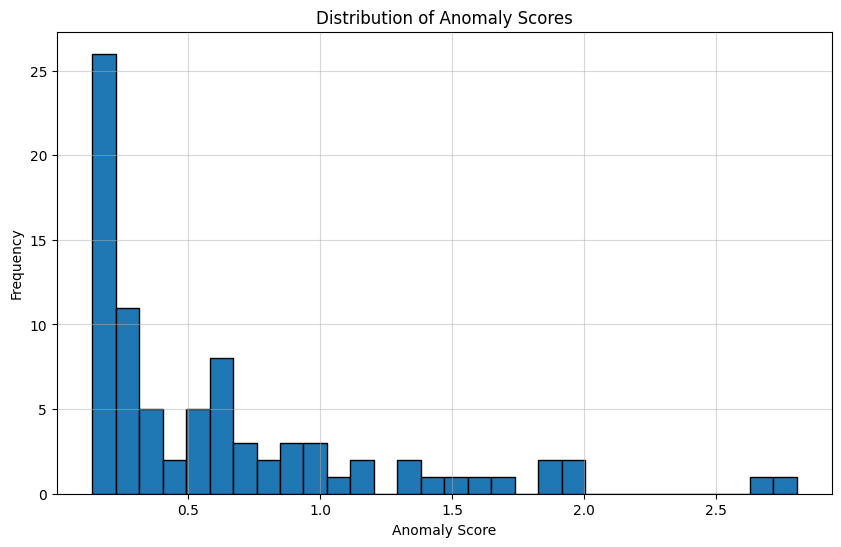

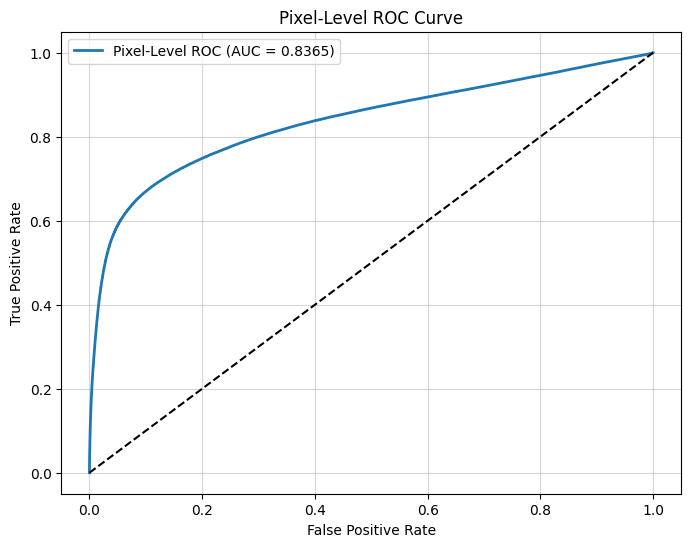

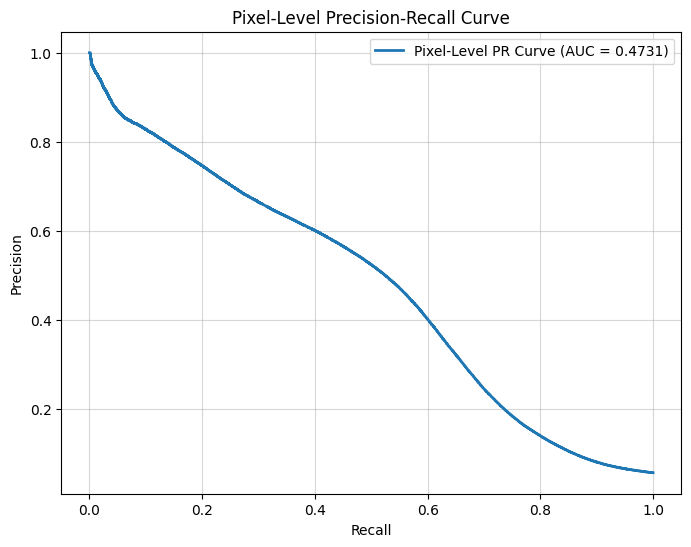

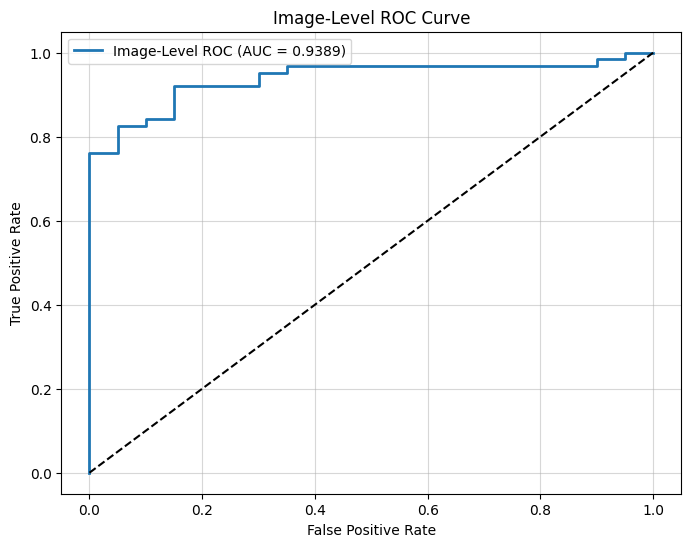

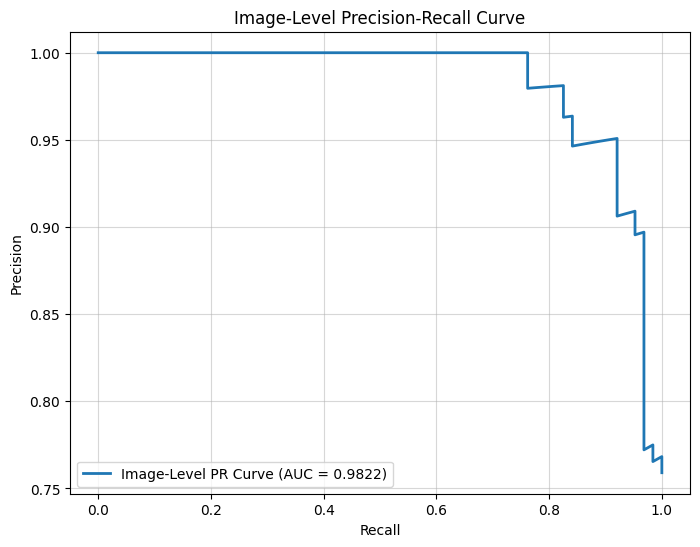

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, auc

# Load saved data
data = np.load('results.npz')
gt_list_px = data['gt_list_px']
pred_list_px = data['pred_list_px']
gt_list_sp = data['gt_list_sp']
pred_list_sp = data['pred_list_sp']

# ==================== 1. Histogram of Anomaly Scores ====================
plt.figure(figsize=(10, 6))
plt.hist(pred_list_sp, bins=30, edgecolor='black')
plt.title('Distribution of Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.5)
plt.show()

# ==================== 2. ROC Curve for Pixel-Level Detection ====================
fpr_px, tpr_px, _ = roc_curve(gt_list_px, pred_list_px)
plt.figure(figsize=(8, 6))
plt.plot(fpr_px, tpr_px, label=f'Pixel-Level ROC (AUC = {roc_auc_score(gt_list_px, pred_list_px):.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Pixel-Level ROC Curve')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

# ==================== 3. Precision-Recall Curve for Pixel-Level ====================
precision_px, recall_px, _ = precision_recall_curve(gt_list_px, pred_list_px)
plt.figure(figsize=(8, 6))
plt.plot(recall_px, precision_px, label=f'Pixel-Level PR Curve (AUC = {auc(recall_px, precision_px):.4f})', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Pixel-Level Precision-Recall Curve')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

# ==================== 4. Image-Level ROC Curve ====================
fpr_img, tpr_img, _ = roc_curve(gt_list_sp, pred_list_sp)
plt.figure(figsize=(8, 6))
plt.plot(fpr_img, tpr_img, label=f'Image-Level ROC (AUC = {roc_auc_score(gt_list_sp, pred_list_sp):.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Image-Level ROC Curve')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

# ==================== 5. Image-Level Precision-Recall Curve ====================
precision_img, recall_img, _ = precision_recall_curve(gt_list_sp, pred_list_sp)
plt.figure(figsize=(8, 6))
plt.plot(recall_img, precision_img, label=f'Image-Level PR Curve (AUC = {auc(recall_img, precision_img):.4f})', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Image-Level Precision-Recall Curve')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()


# Applying Draem Paper Model Architecture to Severstal Steel Dataset

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install required packages
!pip install torch torchvision scikit-image scikit-learn matplotlib opencv-python kornia tqdm

# Create project directory
import os
import sys

# Set up project directory - modify this path to match your Drive structure
PROJECT_DIR = '/content/Severstal_Steel_DRAEM_implementation'
!mkdir -p {PROJECT_DIR}
%cd {PROJECT_DIR}

# Create directory structure
!mkdir -p checkpoints/Severstal
!mkdir -p visualizations/Severstal

# Add current directory to path
sys.path.append(PROJECT_DIR)


Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 87.3 MB/s eta 0:00:00
  Attempting uninstall:

In [ ]:
%%writefile model.py
import torch
import torch.nn as nn

class DiscriminativeSubNetwork(nn.Module):
    def __init__(self, in_channels=6, out_channels=4):
        super(DiscriminativeSubNetwork, self).__init__()
        # Encoder (downsampling)
        self.conv1 = nn.Conv2d(in_channels, 64, 4, stride=2, padding=1, bias=False)  # 128x128
        self.conv2 = nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False)         # 64x64
        self.conv3 = nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=False)        # 32x32
        self.conv4 = nn.Conv2d(256, 512, 4, stride=2, padding=1, bias=False)        # 16x16

        # Decoder (upsampling)
        self.upconv1 = nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False)  # 32x32
        self.upconv2 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False)  # 64x64
        self.upconv3 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False)   # 128x128
        self.upconv4 = nn.ConvTranspose2d(64, out_channels, 4, stride=2, padding=1, bias=False,output_padding=0)  # 256x256

        # Batch normalization
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.batchnorm3 = nn.BatchNorm2d(256)
        self.batchnorm4 = nn.BatchNorm2d(512)
        self.batchnorm5 = nn.BatchNorm2d(256)
        self.batchnorm6 = nn.BatchNorm2d(128)
        self.batchnorm7 = nn.BatchNorm2d(64)

        self.ReLU = nn.ReLU(True)
        self.Dropout = nn.Dropout(0.2)

    def forward(self, x):
        # Encoder path with dropout
        x1 = self.ReLU(self.batchnorm1(self.conv1(x)))
        x1 = self.Dropout(x1)
        x2 = self.ReLU(self.batchnorm2(self.conv2(x1)))
        x2 = self.Dropout(x2)
        x3 = self.ReLU(self.batchnorm3(self.conv3(x2)))
        x3 = self.Dropout(x3)
        x4 = self.ReLU(self.batchnorm4(self.conv4(x3)))
        x4 = self.Dropout(x4)

        # Decoder path with skip connections
        x = self.ReLU(self.batchnorm5(self.upconv1(x4)))
        x = x + x3  # Skip connection
        x = self.ReLU(self.batchnorm6(self.upconv2(x)))
        x = x + x2  # Skip connection
        x = self.ReLU(self.batchnorm7(self.upconv3(x)))
        x = x + x1  # Skip connection
        x = self.upconv4(x)

        return x


class ReconstructiveSubNetwork(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, base_width=128):
        super(ReconstructiveSubNetwork, self).__init__()
        self.encoder = EncoderBlock(in_channels, base_width)
        self.decoder = DecoderBlock(base_width, out_channels)

    def forward(self, x):
        b5 = self.encoder(x)
        output = self.decoder(b5)

        return output

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(in_channels, in_channels//2, 4, stride=2, padding=1, bias=False)
        self.deconv2 = nn.ConvTranspose2d(in_channels//2, in_channels//4, 4, stride=2, padding=1, bias=False)
        self.deconv3 = nn.ConvTranspose2d(in_channels//4, in_channels//8, 4, stride=2, padding=1, bias=False)
        self.deconv4 = nn.ConvTranspose2d(in_channels//8, in_channels//16, 4, stride=2, padding=1, bias=False)
        self.deconv5 = nn.ConvTranspose2d(in_channels//16, out_channels, 4, stride=2, padding=1, bias=False)

        self.batchnorm1 = nn.BatchNorm2d(in_channels//2)
        self.batchnorm2 = nn.BatchNorm2d(in_channels//4)
        self.batchnorm3 = nn.BatchNorm2d(in_channels//8)
        self.batchnorm4 = nn.BatchNorm2d(in_channels//16)

        self.ReLU = nn.ReLU(True)
        self.Sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.ReLU(self.batchnorm1(self.deconv1(x)))
        x = self.ReLU(self.batchnorm2(self.deconv2(x)))
        x = self.ReLU(self.batchnorm3(self.deconv3(x)))
        x = self.ReLU(self.batchnorm4(self.deconv4(x)))

        x = self.Sigmoid(self.deconv5(x))

        return x

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels//16, 4, stride=2, padding=1, bias=False)
        self.conv2 = nn.Conv2d(out_channels//16, out_channels//8, 4, stride=2, padding=1, bias=False)
        self.conv3 = nn.Conv2d(out_channels//8, out_channels//4, 4, stride=2, padding=1, bias=False)
        self.conv4 = nn.Conv2d(out_channels//4, out_channels//2, 4, stride=2, padding=1, bias=False)
        self.conv5 = nn.Conv2d(out_channels//2, out_channels, 4, stride=2, padding=1, bias=False)

        self.batchnorm1 = nn.BatchNorm2d(out_channels//16)
        self.batchnorm2 = nn.BatchNorm2d(out_channels//8)
        self.batchnorm3 = nn.BatchNorm2d(out_channels//4)
        self.batchnorm4 = nn.BatchNorm2d(out_channels//2)
        self.batchnorm5 = nn.BatchNorm2d(out_channels)

        self.ReLU = nn.ReLU(True)

    def forward(self, x):
        x = self.ReLU(self.batchnorm1(self.conv1(x)))
        x = self.ReLU(self.batchnorm2(self.conv2(x)))
        x = self.ReLU(self.batchnorm3(self.conv3(x)))
        x = self.ReLU(self.batchnorm4(self.conv4(x)))
        x = self.ReLU(self.batchnorm5(self.conv5(x)))

        return x


Writing model.py


In [ ]:
%%writefile draem_model.py
import torch
import torch.nn as nn
from model import ReconstructiveSubNetwork, DiscriminativeSubNetwork

class DRAEM(nn.Module):
    def __init__(self):
        super(DRAEM, self).__init__()
        self.reconstructive_subnetwork = ReconstructiveSubNetwork()
        self.discriminative_subnetwork = DiscriminativeSubNetwork(in_channels=6)

    def forward(self, *args, mode="train"):
      with torch.amp.autocast(device_type='cuda'):
          if mode == "train":
              # Unpack all 3 required tensors for training
              perturbed, original, mask = args
              reconstructed = self.reconstructive_subnetwork(perturbed)
              combined = torch.cat([reconstructed, original], dim=1)
              output = self.discriminative_subnetwork(combined)
              return reconstructed, output

          elif mode == "test":
              # Single input for validation/testing
              x = args[0]
              reconstructed = self.reconstructive_subnetwork(x)
              output = self.discriminative_subnetwork(torch.cat([x, reconstructed], dim=1))
              return reconstructed, output


Writing draem_model.py


In [ ]:
%%writefile dataset.py
import os
import cv2
import torch
import glob
import time
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from torchvision import transforms
from PIL import Image
from torchvision.transforms import InterpolationMode

def get_data_transforms(size, isize):
    image_transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.RandomApply([
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
            transforms.GaussianBlur(3, sigma=(0.1, 2.0)),  # Added
            transforms.RandomAdjustSharpness(2)  # Added
        ], p=0.5),
        transforms.RandomAffine(degrees=15, translate=(0.2, 0.2), scale=(0.8, 1.2)),  # Modified
        transforms.ToTensor(),
        transforms.RandomErasing(p=0.3, scale=(0.02, 0.25), ratio=(0.3, 3.3)),  # Modified
    ])

    mask_transform = transforms.Compose([
        transforms.Resize((size, size), interpolation=InterpolationMode.NEAREST),
    ])
    return image_transform, mask_transform

class SeverstalDataset(Dataset):
    def __init__(self, root_dir, csv_file, image_transform=None, mask_transform=None,
                 phase='train', subset_size=None, split_ratio=0.8, random_state=42,
                 oversampling=True,img_size=192):  # Added oversampling parameter
        self.root_dir = root_dir
        self.img_size = img_size
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.phase = phase
        self.oversampling = oversampling

        df = pd.read_csv(os.path.join(root_dir, csv_file))
        # Calculate class weights
        raw_class_counts = df['ClassId'].value_counts().sort_index()
        total_samples = len(df)
        self.class_weights = total_samples / (raw_class_counts + 1e-7)
        print(f"True Class Weights: {self.class_weights.to_dict()}")

        # Build image-defect mapping
        self.image_defect_map = df.groupby('ImageId')['ClassId'].apply(set).to_dict()

        # Stratified split
        unique_images = df['ImageId'].unique()
        train_ids, val_ids = train_test_split(
            unique_images,
            test_size=1-split_ratio,
            stratify=df.groupby('ImageId')['ClassId'].first(),
            random_state=random_state
        )

        self.img_ids = train_ids if phase == 'train' else val_ids

        # Oversampling logic for training
        if subset_size and phase == 'train' and self.oversampling:
            # Prioritize rare defects (1,3,4)
            rare_defect_imgs = [
                img_id for img_id in self.img_ids
                if any(d in {1,3,4} for d in self.image_defect_map.get(img_id, set()))
            ]

            # Sample 60% rare defects
            rare_size = int(subset_size * 0.6)
            if len(rare_defect_imgs) > 0:
                rare_samples = np.random.choice(
                    rare_defect_imgs,
                    size=min(len(rare_defect_imgs), rare_size),
                    replace=False
                )
                remaining = subset_size - len(rare_samples)
            else:
                rare_samples = []
                remaining = subset_size

            # Sample remaining from all
            regular_samples = np.random.choice(
                [img_id for img_id in self.img_ids if img_id not in rare_samples],
                size=remaining,
                replace=False
            )

            self.img_ids = list(rare_samples) + list(regular_samples)
            np.random.shuffle(self.img_ids)
        elif subset_size:
            self.img_ids = self.img_ids[:subset_size]

        self.df = df[df['ImageId'].isin(self.img_ids)]
        print(f"Class distribution:\n{self.df['ClassId'].value_counts()}")
        self.img_paths = [os.path.join(root_dir, 'train', img_id) for img_id in self.img_ids]

    def __len__(self):
        return len(self.img_paths)

    @staticmethod
    def collate_fn(batch):
        images, masks, ids = zip(*batch)
        return torch.stack(images), torch.stack(masks), ids

    def __getitem__(self, idx):
        img_id = self.df.iloc[idx]['ImageId']
        img_path = os.path.join(self.root_dir, "train", img_id)  # Corrected path

        image = Image.open(img_path).convert('RGB')
        mask = torch.zeros((4, self.img_size, self.img_size), dtype=torch.float32)

        defect_rows = self.df[self.df['ImageId'] == img_id]

        for _, row in defect_rows.iterrows():
            class_id = int(row['ClassId']) - 1  # Now correctly parsed
            if pd.notna(row['EncodedPixels']):
                mask_img = self.rle2mask(row['EncodedPixels'], (self.img_size, self.img_size))
                mask[class_id] = mask_img

        # Debug print
        print(f"Image: {img_id} | Classes present: {torch.unique(torch.argmax(mask, dim=0))}")

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask, img_id

    def rle2mask(self, rle, shape):
        mask = np.zeros(shape[0]*shape[1], dtype=np.uint8)
        if pd.isna(rle):  # Handle potential NaN values
            return torch.zeros(shape, dtype=torch.float32)

        array = np.asarray([int(x) for x in str(rle).split()])
        starts, lengths = array[0::2], array[1::2]

        for start, length in zip(starts, lengths):
            mask[start:start+length] = 1
        return torch.from_numpy(mask.reshape(shape, order='F')).float()

class CutPasteDataset(Dataset):
    def __init__(self, root, transform, perturbed_transform, phase, args):
        self.img_path = os.path.join(root, 'train')
        self.transform = transform
        self.perturbed_transform = perturbed_transform
        self.img_paths = sorted(glob.glob(os.path.join(self.img_path, "*.jpg")))
        self.img_paths += sorted(glob.glob(os.path.join(self.img_path, "*.png")))
        self.args = args

        # Anomaly source handling
        self.anomaly_source_paths = []
        if os.path.exists(args.anomaly_source_path):
            self.anomaly_source_paths = [
                os.path.join(args.anomaly_source_path, f)
                for f in os.listdir(args.anomaly_source_path)
                if f.lower().endswith(('.png', '.jpg', '.jpeg'))
            ]

        if not self.anomaly_source_paths:
            self.create_synthetic_textures(args.anomaly_source_path)
            self.anomaly_source_paths = [
                os.path.join(args.anomaly_source_path, f)
                for f in os.listdir(args.anomaly_source_path)
                if f.lower().endswith(('.png', '.jpg', '.jpeg'))
            ]

        self.resize_transform = transforms.Resize((args.img_size, args.img_size))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        idx = idx % len(self.img_paths)
        img_path = self.img_paths[idx]

        # Load base image
        img = Image.open(img_path).convert('RGB')
        img = self.transform(img)

        # Generate anomaly
        anomaly_img, mask = self.generate_anomaly(img)
        return img, anomaly_img, mask, img_path

    def get_anomaly_source(self, mask_h, mask_w):
        source_path = np.random.choice(self.anomaly_source_paths)
        source = Image.open(source_path).convert('RGB')

        transform = transforms.Compose([
            transforms.Resize((mask_h*2, mask_w*2)),  # Oversample
            transforms.RandomAffine(degrees=15, shear=10),
            transforms.RandomPerspective(distortion_scale=0.3),
            transforms.CenterCrop((mask_h, mask_w)),
            transforms.ToTensor(),
        ])
        return transform(source)
    def generate_anomaly(self, img):
        anomaly_img = img.clone()
        h, w = img.shape[1], img.shape[2]

        # Realistic defect type distribution
        defect_probs = [0.20, 0.05, 0.65, 0.10]  # Matches Severstal class frequencies
        defect_type = np.random.choice([1,2,3,4], p=defect_probs)

        # Defect-specific sizing with random aspect ratios
        if defect_type in [2,3]:
            base_size = random.randint(2,15)
            mask_h = int(base_size * np.random.uniform(0.8, 1.2))  # 1.6-18px
            mask_w = int(base_size * np.random.uniform(0.8, 1.2))
        else:
            base_size = random.randint(20,50)
            mask_h = int(base_size * np.random.uniform(0.7, 1.3))  # 14-65px
            mask_w = int(base_size * np.random.uniform(0.7, 1.3))

        # Allow border defects (remove -1)
        y = np.random.randint(0, h - mask_h)
        x = np.random.randint(0, w - mask_w)

        # Enhanced anomaly source
        anomaly_source = self.get_anomaly_source(mask_h, mask_w)

        # Apply with random rotation/affine
        angle = random.uniform(-45,45)
        anomaly_source = TF.rotate(anomaly_source, angle)

        anomaly_img[:, y:y+mask_h, x:x+mask_w] = anomaly_source
        mask = torch.zeros((1, h, w))
        mask[:, y:y+mask_h, x:x+mask_w] = 1

        return anomaly_img, mask

    def create_synthetic_textures(self, output_path):
        os.makedirs(output_path, exist_ok=True)
        for i in range(20):
            # Create random texture patterns
            texture = np.random.randint(0, 256, (256,256,3), dtype=np.uint8)
            cv2.imwrite(os.path.join(output_path, f"synth_{i}.jpg"), texture)


Writing dataset.py


In [ ]:
%%writefile train_DRAEM.py
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm
import argparse
import os
import numpy as np
from dataset import SeverstalDataset, get_data_transforms
from draem_model import DRAEM
from sklearn.metrics import f1_score

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

class FocalLoss(torch.nn.Module):
    def __init__(self, gamma=2.0, alpha=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha  # Should be tensor of shape [4]

    def forward(self, inputs, targets):
        # inputs: (N,4,H,W), targets: (N,4,H,W)
        BCE_loss = torch.nn.functional.binary_cross_entropy_with_logits(
            inputs, targets, reduction='none', pos_weight=self.alpha.view(1,-1,1,1)
        )
        pt = torch.exp(-BCE_loss)
        F_loss = (1 - pt)**self.gamma * BCE_loss
        return F_loss.mean()

def main():
    parser = argparse.ArgumentParser(description='DRAEM Training')
    parser.add_argument('--obj_name', default='severstal', type=str)
    parser.add_argument('--checkpoint_path', default='checkpoints/severstal/model_best.pth', type=str)
    parser.add_argument('--data_path', required=True, type=str)
    parser.add_argument('--epochs', default=10, type=int)
    parser.add_argument('--lr', default=5e-4, type=float)
    parser.add_argument('--grad_accum', default=4, type=int)
    parser.add_argument('--img_size', default=256, type=int)
    parser.add_argument('--bs', default=16, type=int)
    parser.add_argument('--seed', default=111, type=int)
    parser.add_argument('--subset_size', default=4000, type=int)
    parser.add_argument('--oversampling', action='store_true', help='Enable class-balanced oversampling')
    parser.add_argument('--focal_gamma', type=float, default=2.0)
    parser.add_argument('--l1_weight', type=float, default=0.5)
    parser.add_argument('--grad_clip', type=float, default=1.0)

    args = parser.parse_args()
    setup_seed(args.seed)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print(f"\n=== CUDA Status ===")
    print(f"CUDA available: {torch.cuda.is_available()}")
    print(f"Device: {device}")

    image_transform, mask_transform = get_data_transforms(args.img_size, args.img_size)

    train_dataset = SeverstalDataset(
        root_dir=args.data_path,
        csv_file='train.csv',
        image_transform=image_transform,
        mask_transform=mask_transform,
        phase='train',
        subset_size=args.subset_size,
        split_ratio=0.8,
        random_state=args.seed,
        oversampling=args.oversampling,
        img_size=args.img_size
    )

    val_dataset = SeverstalDataset(
        root_dir=args.data_path,
        csv_file='train.csv',
        image_transform=image_transform,
        mask_transform=mask_transform,
        phase='val',
        subset_size=None,
        split_ratio=0.8,
        random_state=args.seed,
        img_size=args.img_size
    )

    class_weights = torch.tensor(train_dataset.class_weights.values,
                               dtype=torch.float32).to(device)
    print(f"Using class weights: {class_weights.cpu().numpy()}")

    train_dataloader = DataLoader(train_dataset, batch_size=args.bs, shuffle=True,collate_fn=SeverstalDataset.collate_fn,num_workers=2, pin_memory=True)
    val_dataloader = DataLoader(val_dataset, batch_size=args.bs, shuffle=False, collate_fn=SeverstalDataset.collate_fn,num_workers=2, pin_memory=True)

    print(f"\nTraining samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")

    model = DRAEM().to(device)

    optimizer = optim.AdamW(model.parameters(), lr=args.lr, weight_decay=1e-4)

    def warmup_cosine_schedule(epoch, warmup_epochs=2, total_epochs=args.epochs):
        if total_epochs <= warmup_epochs:
            return min(epoch/warmup_epochs, 1.0)
        return 0.5*(1 + np.cos(np.pi*(epoch - warmup_epochs)/(total_epochs - warmup_epochs)))

    scheduler = torch.optim.lr_scheduler.LambdaLR(
        optimizer, lr_lambda=lambda epoch: warmup_cosine_schedule(epoch)
    )

    focal_loss = FocalLoss(gamma=2.0, alpha=class_weights)
    best_f1 = 0

    for epoch in range(args.epochs):
        model.train()
        epoch_loss = 0
        pbar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{args.epochs}")
        total_batches = len(train_dataloader)

        for batch_idx, batch in enumerate(pbar):
            original_img, mask, _ = batch
            original_img = original_img.to(device, non_blocking=True)
            mask = mask.to(device, non_blocking=True)

            # Add debug prints in training loop
            print(f"Mask stats - Min: {mask.min()}, Max: {mask.max()}, Mean: {mask.float().mean().item()}")
            print(f"Training Batch {batch_idx+1} - Positive pixels per class: {mask.float().sum(dim=[0,2,3]).cpu().numpy()}")

            mask_combined = mask.sum(dim=1, keepdim=True).float().clamp(0, 1)
            noise = torch.randn_like(original_img) * mask_combined
            perturbed_img = original_img * (1 - mask_combined) + noise
            perturbed_img = torch.clamp(perturbed_img, 0, 1)

            with torch.amp.autocast(device_type='cuda'):
                reconstructed, output = model(perturbed_img, original_img, mask, mode="train")

                print(f"Output stats - Min: {output.min().item()}, Max: {output.max().item()}")

                l1_loss = torch.mean(torch.abs(reconstructed - original_img))
                segment_loss = focal_loss(output, mask.float())
                loss = l1_loss + segment_loss

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            if (batch_idx + 1) % args.grad_accum == 0 or (batch_idx + 1) == total_batches:
                optimizer.step()
                optimizer.zero_grad()

            epoch_loss += loss.item()
            pbar.set_postfix({"Loss": loss.item()})

        # Validation with class-aware metrics
        optimizer.zero_grad(set_to_none=True)  # Clear any remaining gradients
        torch.cuda.empty_cache()
        model.eval()
        all_preds = []
        all_targets = []
        val_loss = 0

        with torch.no_grad(), torch.amp.autocast(device_type='cuda'):
            print("\n=== Validation Phase ===")
            val_pbar = tqdm(val_dataloader, desc=f"Validating Epoch {epoch+1}")
            for val_batch in val_pbar:
                val_img, val_mask, _ = val_batch
                print(f"Validation Batch - Image shape: {val_img.shape}, Mask shape: {val_mask.shape}")
                print(f"Validation Batch - Positive pixels per class: {val_mask.float().sum(dim=[0,2,3]).cpu().numpy()}")
                if val_img.device != device:
                    print(f"Correcting device mismatch: {val_img.device} -> {device}")
                    val_img = val_img.to(device, non_blocking=True)
                    val_mask = val_mask.to(device, non_blocking=True)

                if torch.isnan(val_img).any():
                    print("NaN detected in validation images!")
                if torch.isnan(val_mask).any():
                    print("NaN detected in validation masks!")

                val_reconstructed, val_output = model(val_img, mode="test")

                # Calculate losses
                l1_val_loss = torch.mean(torch.abs(val_reconstructed - val_img))
                segment_val_loss = focal_loss(val_output, val_mask.float())
                val_loss += (l1_val_loss + segment_val_loss).item()

                # Move to CPU immediately and convert
                preds = torch.sigmoid(val_output).cpu().float()
                targets = val_mask.cpu().float()
                all_preds.append(preds)
                all_targets.append(targets)

        # Calculate F1 scores
        all_preds = torch.cat(all_preds)
        all_targets = torch.cat(all_targets)

        # Release GPU memory before metrics
        del val_reconstructed, val_output, val_img, val_mask
        torch.cuda.synchronize()  # Wait for CUDA ops to finish
        torch.cuda.empty_cache()
        print(f"GPU Memory After: {torch.cuda.memory_allocated()/1e9:.2f}GB")

        f1_scores = []
        for c in range(4):
            preds_class = (all_preds[:,c] > 0.1).float()
            targets_class = all_targets[:,c].float()
            f1 = f1_score(targets_class.numpy().flatten(),
                        preds_class.numpy().flatten(),
                        zero_division=0)
            f1_scores.append(f1)

        avg_f1 = np.mean(f1_scores)
        print(f"\nValidation F1 Scores:")
        print(f"Class 1: {f1_scores[0]:.4f} | Class 2: {f1_scores[1]:.4f}")
        print(f"Class 3: {f1_scores[2]:.4f} | Class 4: {f1_scores[3]:.4f}")
        print(f"Macro Avg F1: {avg_f1:.4f}")

        # Save best model based on F1
        if avg_f1 > best_f1:
            torch.save(model.state_dict(), args.checkpoint_path)
            best_f1 = avg_f1
            print(f"New best model saved with F1: {avg_f1:.4f}")

        scheduler.step()

if __name__ == '__main__':
    main()


Writing train_DRAEM.py


In [ ]:
%%writefile test_DRAEM.py
import torch
from torch.utils.data import DataLoader,Subset
import argparse
import os
import numpy as np
from tqdm import tqdm
from sklearn.metrics import classification_report
from dataset import SeverstalDataset, get_data_transforms
from draem_model import DRAEM
import cv2
import psutil
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_recall_curve
from torchvision.transforms import InterpolationMode

def parse_args():
    parser = argparse.ArgumentParser(description='DRAEM Multi-Class Testing with Visualization')
    parser.add_argument('--obj_name', type=str, default='severstal',
                        help='Object category name')
    parser.add_argument('--data_path', type=str, required=True,
                        help='Path to dataset directory containing train.csv and images')
    parser.add_argument('--checkpoint_path', type=str,
                        default='checkpoints/severstal/model_best.pth',
                        help='Path to the trained model checkpoint')
    parser.add_argument('--test_samples', type=int, default=0,
                       help='Number of test samples (0=use all)')
    parser.add_argument('--save_path', type=str,
                        default='visualizations/severstal',
                        help='Directory to save output visualizations')
    parser.add_argument('--img_size', type=int, default=128,
                        help='Input image size for the model')
    return parser.parse_args()

def validate_paths(args):
    if not os.path.exists(args.data_path):
        raise FileNotFoundError(f"Data path not found: {args.data_path}")

    train_csv = os.path.join(args.data_path, 'train.csv')
    if not os.path.exists(train_csv):
        raise FileNotFoundError(f"train.csv missing in {args.data_path}")

    if not os.path.isfile(args.checkpoint_path):
        raise FileNotFoundError(f"Checkpoint file not found: {args.checkpoint_path}")

    return args.checkpoint_path

def optimize_thresholds(outputs, masks, num_classes=4):
    # Resize outputs to match mask dimensions
    outputs_resized = torch.nn.functional.interpolate(
        outputs,
        size=masks.shape[-2:],
        mode='nearest'
    )

    outputs_np = outputs_resized.cpu().numpy()
    masks_np = masks.cpu().numpy()

    best_thresholds = []
    for c in range(num_classes):
        if np.sum(masks_np[:,c]) == 0:
            best_thresholds.append(0.5)
            continue

        # Ensure equal length
        y_true = masks_np[:,c].flatten()
        y_score = outputs_np[:,c].flatten()

        precisions, recalls, thresholds = precision_recall_curve(y_true, y_score)

        f1_scores = 2 * precisions * recalls / (precisions + recalls + 1e-7)
        best_idx = np.nanargmax(f1_scores)
        best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5
        best_thresholds.append(float(best_threshold))

    return best_thresholds

def visualize_results(image, anomaly_map, pred_classes, save_dir, base_name):
    try:
        if isinstance(anomaly_map, torch.Tensor):
            anomaly_map = anomaly_map.cpu().numpy()

        if anomaly_map.ndim > 2:
            anomaly_map = anomaly_map.squeeze()

        eps = 1e-7
        anomaly_map = anomaly_map.astype(np.float32) + eps

        anomaly_norm = np.zeros_like(anomaly_map, dtype=np.uint8)
        cv2.normalize(anomaly_map, anomaly_norm, 0, 255, cv2.NORM_MINMAX)

        heatmap = cv2.applyColorMap(anomaly_norm, cv2.COLORMAP_JET)
        blended = cv2.addWeighted(image, 0.7, heatmap, 0.3, 0)

        cv2.imwrite(os.path.join(save_dir, f"{base_name}_original.png"),
                    cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        cv2.imwrite(os.path.join(save_dir, f"{base_name}_anomaly.png"), anomaly_norm)
        cv2.imwrite(os.path.join(save_dir, f"{base_name}_heatmap.png"), blended)

    except Exception as e:
        print(f"Skipping visualization for {base_name}: {str(e)}")

def main():
    args = parse_args()
    checkpoint_path = validate_paths(args)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    data_transform, _ = get_data_transforms(args.img_size, args.img_size)

    # Modified line: Add subset_size parameter
    full_dataset = SeverstalDataset(
        args.data_path,
        'train.csv',
        data_transform,
        phase='val',
        split_ratio=0.8,
        # subset_size=args.test_samples if args.test_samples > 0 else None,
        subset_size = None,
        random_state=42,
    )
    if args.test_samples > 0:
        test_dataset = Subset(full_dataset, indices=range(min(args.test_samples, len(full_dataset))))
    else:
        test_dataset = full_dataset

    print(f"Loaded {len(test_dataset)} validation samples.")

    test_dataloader = DataLoader(
        test_dataset,
        batch_size=4,  # Reduced batch size for memory
        shuffle=False,
        pin_memory=True,
        persistent_workers=False,
        num_workers=2
    )

    model = DRAEM().to(device)
    print("\nLoading checkpoint...")
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint)
    model.eval()

    print("\n=== Calculating Optimal Thresholds ===")
    threshold_outputs = []
    threshold_masks = []

    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Threshold Optimization"):
            images, masks, _ = batch
            images = images.to(device)
            _, output = model(images, mode="test")
            threshold_outputs.append(output.cpu())
            threshold_masks.append(masks.cpu())

    threshold_outputs = torch.cat(threshold_outputs)
    threshold_masks = torch.cat(threshold_masks)
    class_thresholds = optimize_thresholds(threshold_outputs, threshold_masks)
    print(f"Optimal Class Thresholds: {class_thresholds}")

    pred_classes_list = []
    true_classes_list = []

    print("\nRunning inference...")
    with torch.no_grad():
        batch_counter = 0
        for batch in tqdm(test_dataloader, desc="Processing batches"):
            images, masks, paths = batch
            images = images.to(device)
            masks = masks.to(device)

            _, output = model(images, mode="test")

            batch_preds = torch.zeros_like(output)
            for c in range(4):
                batch_preds[:,c] = (torch.sigmoid(output[:,c]) > class_thresholds[c]).float()

            pred_classes = batch_preds.any(dim=2).any(dim=2).cpu().numpy().astype(int)
            true_classes = (masks > 0.5).any(dim=3).any(dim=2).cpu().numpy().astype(int)

            pred_classes_list.extend(pred_classes.flatten())
            true_classes_list.extend(true_classes.flatten())

            if batch_counter % 10 == 0:
                images_np = images.cpu().numpy().transpose(0, 2, 3, 1) * 255
                output_np = output.cpu().numpy()
                for i in range(images_np.shape[0]):
                    base_name = os.path.basename(paths[i])
                    visualize_results(
                        image=images_np[i].astype(np.uint8),
                        anomaly_map=output_np[i].max(axis=0),
                        pred_classes=pred_classes[i],
                        save_dir=args.save_path,
                        base_name=base_name.split('.')[0]
                    )
                del images_np, output_np

            del images, masks, output
            torch.cuda.empty_cache()

            print(f"Memory usage: {psutil.virtual_memory().percent}%")
            batch_counter += 1

    print("\n=== Evaluation Metrics ===")
    print(classification_report(
        true_classes_list,
        pred_classes_list,
        labels=[0,1,2,3],
        target_names=['defect_1', 'defect_2', 'defect_3', 'defect_4'],
        zero_division=0
    ))
    print("Balanced Accuracy:", balanced_accuracy_score(true_classes_list, pred_classes_list))
if __name__ == '__main__':
    try:
        main()
    except Exception as e:
        print(f"\nError during testing: {str(e)}")
        import traceback
        traceback.print_exc()


Writing test_DRAEM.py


In [ ]:
%%writefile run_reproduction.py
import argparse
import os
import subprocess
import time
import pandas as pd
import torch

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

def run_command(command):
    print(f"Running: {command}")
    process = subprocess.run(command, shell=True)
    return process.returncode == 0

def main():
    parser = argparse.ArgumentParser(description='DRAEM Steel Defect Detection Reproduction')
    parser.add_argument('--obj_name', default='severstal', type=str)
    parser.add_argument('--severstal_path', required=True, type=str)
    parser.add_argument('--epochs', default=10, type=int)
    parser.add_argument('--bs', default=8, type=int)
    parser.add_argument('--lr', default=1e-4, type=float)
    parser.add_argument('--img_size', default=128, type=int)
    parser.add_argument('--subset_size', default=5000, type=int)
    parser.add_argument('--seed', default=42, type=int)
    parser.add_argument('--grad_accum', default=4, type=int)
    parser.add_argument('--focal_gamma', default=2.0, type=float)
    parser.add_argument('--l1_weight', default=0.5, type=float)
    parser.add_argument('--grad_clip', default=1.0, type=float)
    parser.add_argument('--oversampling', action='store_true')
    parser.add_argument('--train_only', action='store_true', help='Only run training, skip testing')
    parser.add_argument('--test_only', action='store_true', help='Only run testing, skip training')
    parser.add_argument('--test_samples', default=0, type=int,
                   help='Number of test samples to evaluate (0=all)')

    args = parser.parse_args()
    setup_seed(args.seed)

    # Validate mutually exclusive arguments
    if args.train_only and args.test_only:
        raise ValueError("Cannot specify both --train_only and --test_only")

    # Check for GPU availability
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Verify paths
    print("=== Verifying dataset paths ===")
    if not os.path.exists(args.severstal_path):
        raise FileNotFoundError(f"Severstal dataset path {args.severstal_path} not found!")

    # Only check training data if not in test-only mode
    if not args.test_only:
        train_csv = os.path.join(args.severstal_path, 'train.csv')
        if not os.path.exists(train_csv):
            raise FileNotFoundError(f"Training CSV file {train_csv} not found!")

    # Always check test data
    test_folder = os.path.join(args.severstal_path, 'test')
    if not os.path.exists(test_folder):
        raise FileNotFoundError(f"Test folder {test_folder} not found!")

    # Print dataset information
    if not args.test_only:
        train_df = pd.read_csv(os.path.join(args.severstal_path, 'train.csv'))
        print(f"Found {len(train_df)} training samples")

    test_images = [f for f in os.listdir(test_folder) if f.endswith(('.jpg', '.png'))]
    print(f"Found {len(test_images)} test images")

    # Create necessary directories
    os.makedirs('checkpoints/severstal', exist_ok=True)
    os.makedirs('visualizations/severstal', exist_ok=True)

    start_time = time.time()

    # Training workflow
    if not args.test_only:
        print("\n=== Training DRAEM model ===")
        train_cmd = (
            f"python train_DRAEM.py "
            f"--obj_name {args.obj_name} "
            f"--data_path {args.severstal_path} "
            f"--epochs {args.epochs} "
            f"--bs {args.bs} "
            f"--lr {args.lr} "
            f"--img_size {args.img_size} "
            f"--subset_size {args.subset_size} "
            f"--seed {args.seed} "
            f"--grad_accum {args.grad_accum} "
            f"--focal_gamma {args.focal_gamma} "
            f"--l1_weight {args.l1_weight} "
            f"--grad_clip {args.grad_clip} "
            f"{'--oversampling' if args.oversampling else ''}"
        )
        if not run_command(train_cmd):
            raise RuntimeError("Training failed!")

    # Testing workflow
    if not args.train_only:
        print("\n=== Testing DRAEM model ===")
        checkpoint_path = '/content/Severstal_Steel_DRAEM_implementation/checkpoints/severstal/model_best.pth'
        if not os.path.exists(checkpoint_path):
            raise FileNotFoundError(f"Checkpoint {checkpoint_path} not found! Train first.")

        # Add space after {args.test_samples}
        test_cmd = (f"python test_DRAEM.py "
                    f"--data_path {args.severstal_path} "
                    f"--checkpoint_path {checkpoint_path} "
                    f"--test_samples {args.test_samples} "  # Space added here
                    f"--img_size {args.img_size}")

        if not run_command(test_cmd):
            raise RuntimeError("Testing failed!")

    total_time = time.time() - start_time
    print(f"\n=== Pipeline completed in {total_time:.2f} seconds ===")

if __name__ == "__main__":
    try:
        main()
    except Exception as e:
        print(f"\nError: {str(e)}")
        exit(1)


Writing run_reproduction.py


In [ ]:
!python run_reproduction.py \
--obj_name severstal \
--severstal_path /content/drive/MyDrive/severstal-steel-defect-detection \
--train_only \
--epochs 10 \
--bs 10 \
--grad_accum 4 \
--lr 3e-4 \
--img_size 160 \
--subset_size 5000 \
--oversampling \
--focal_gamma 2.5 \
--l1_weight 0.7 \
--grad_clip 0.5

Streaming output truncated to the last 5000 lines.
Image: 867572f1e.jpg | Classes present: tensor([0])
Image: e1db7ee54.jpg | Classes present: tensor([0])
Image: 7de00739f.jpg | Classes present: tensor([0])
Image: 933e1967c.jpg | Classes present: tensor([0])
Image: ac97767a7.jpg | Classes present: tensor([0])
Image: bebb35a5e.jpg | Classes present: tensor([0])
Image: e5acd8af8.jpg | Classes present: tensor([0])
Image: 3eec62abe.jpg | Classes present: tensor([0])
Image: 3cfa559c3.jpg | Classes present: tensor([0, 2])
Image: e054a983d.jpg | Classes present: tensor([0])
Mask stats - Min: 0.0, Max: 1.0, Mean: 0.0021298828069120646
Training Batch 250 - Positive pixels per class: [   0.    0. 2181.    0.]
Output stats - Min: -14.671875, Max: 1.9755859375
Epoch 10/10:  50% 250/500 [00:49<00:45,  5.50it/s, Loss=0.0464]Mask stats - Min: 0.0, Max: 1.0, Mean: 0.006922851782292128
Training Batch 251 - Positive pixels per class: [   0.    0. 7089.    0.]
Image: 8f82d86db.jpg | Classes present: tens

In [ ]:
!python run_reproduction.py --severstal_path /content/drive/MyDrive/severstal-steel-defect-detection --test_only --test_samples 0 --img_size 160

Using device: cuda
=== Verifying dataset paths ===
Found 5506 test images

=== Testing DRAEM model ===
Running: python test_DRAEM.py --data_path /content/drive/MyDrive/severstal-steel-defect-detection --checkpoint_path /content/Severstal_Steel_DRAEM_implementation/checkpoints/severstal/model_best.pth --test_samples 0 --img_size 160
Using device: cuda
True Class Weights: {1: 7.909698995773724, 2: 28.724696344645874, 3: 1.3776699028858705, 4: 8.857677901515896}
Class distribution:
ClassId
3    1037
1     180
4     160
2      50
Name: count, dtype: int64
Loaded 1334 validation samples.

Loading checkpoint...

=== Calculating Optimal Thresholds ===
Threshold Optimization:   0% 0/334 [00:00<?, ?it/s]Image: 0025bde0c.jpg | Classes present: tensor([0, 2])
Image: 000a4bcdd.jpg | Classes present: tensor([0])
Image: 000f6bf48.jpg | Classes present: tensor([0])
Image: 0095cd374.jpg | Classes present: tensor([0, 2])
Image: 0014fce06.jpg | Classes present: tensor([0])
Image: 00ac8372f.jpg | Classes